# Movinet Streaming Model Tutorial

This tutorial trains a [MoViNet](https://arxiv.org/abs/2103.11511) with `A0` configuration from the TensorFlow Model Garden package (tensorflow-models).

[Model Garden](https://www.tensorflow.org/tfmodels) contains a collection of state-of-the-art models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

**Streaming Models**:

Streaming models implement causal (2+1)D convolutions with stream buffers. Streaming models use (2+1)D convolution instead of 3D to utilize optimized tf.nn.conv2d operations, which offer fast inference on CPU. Streaming models can be run on individual frames or on larger video clips like base models.

**Note**: A3, A4, and A5 models use a positional encoding in the squeeze-excitation blocks, while A0, A1, and A2 do not. For the smaller models, accuracy is unaffected without positional encoding, while for the larger models accuracy is significantly worse without positional encoding.

**Dataset:** [UCF_101](https://www.tensorflow.org/datasets/catalog/ucf101)
* A 101-label video classification dataset

**This tutorial demonstrates how to:**

* Use models from the TensorFlow Models package.
* Train/Fine-tune a pre-built [MoViNet](https://arxiv.org/abs/2103.11511) for Video Classification.
* Export the trained/tuned MoViNet-A0-Stream model

## Install Necessary libraries

In [1]:
%pip install --upgrade pip
%pip install tensorflow[and-cuda]
%pip install -q "tf-models-official"

# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
%pip install mediapy remotezip
%pip install git+https://github.com/tensorflow/docs

  Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 518.5 kB/s eta 0:00:0000:0100:01
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_cudnn_cu11-8.7.0.84-py3

In [2]:
%pip list --outdated

Package              Version  Latest      Type
-------------------- -------- ----------- -----
absl-py              1.4.0    2.0.0       wheel
google-auth-oauthlib 1.0.0    1.1.0       wheel
ml-dtypes            0.2.0    0.3.1       wheel
nvidia-cudnn-cu11    8.7.0.84 8.9.4.25    wheel
nvidia-nccl-cu11     2.16.5   2.19.3      wheel
protobuf             3.20.3   4.24.4      wheel
setuptools           65.5.0   68.2.2      wheel
tensorboard          2.14.1   2.15.0      wheel
tensorrt             8.5.3.1  8.6.1.post1 sdist
wrapt                1.14.1   1.15.0      wheel
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q imageio numpy seaborn ipywidgets
# !wget https://storage.googleapis.com/thumos14_files/UCF101_videos.zip

Note: you may need to restart the kernel to use updated packages.


In [32]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Import necessary libraries

In [1]:
import tensorflow as tf
import os
import tqdm
import random
import pathlib
import imageio
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from tensorflow_docs.vis import embed

import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import functools
import tensorboard


2023-11-01 19:09:50.844653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 19:09:50.844715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 19:09:50.847884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 19:09:51.071040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.compiler.tf2tensorrt._pywrap_py_utils import get_linked_tensorrt_version
from tensorflow.compiler.tf2tensorrt._pywrap_py_utils import get_loaded_tensorrt_version

print(f"Linked TensorRT version {get_linked_tensorrt_version()}")
print(f"Loaded TensorRT version {get_loaded_tensorrt_version()}")
tf.test.is_built_with_cuda()

Linked TensorRT version (8, 4, 3)
Loaded TensorRT version (8, 5, 3)


True

In [2]:
%load_ext tensorboard

## Import the MoViNet model from TensorFlow Models (tf-models-official)

In [2]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

## Download Subdataset of UCF_101

In [3]:
# @title Helper functions for loading data and visualizing
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=200, loop=0)
  return embed.embed_file('./animation.gif')


class FrameGenerator:
  def __init__(self, path: pathlib.PosixPath, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label
num_classes = None

In [10]:
# Helper functions below used are taken from following tutorials
# https://www.tensorflow.org/tutorials/video/video_classification
# https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet

# URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
URL = pathlib.Path(os.path.join(os.path.abspath(''), 'UCF101_videos.zip'))
!rm -r ./UCF101_subset
download_dir = pathlib.Path('./UCF101_subset/')
num_classes = 101
subset_paths = download_ufc_101_subset(URL,
                        num_classes = num_classes,
                        splits = {"train1": 60, "val": 10},
                        download_dir = download_dir)

train1 :


100%|██████████| 5913/5913 [01:32<00:00, 63.82it/s] 


val :


100%|██████████| 528/528 [00:05<00:00, 89.94it/s] 


## Prepare train, valid and test dataset

In [4]:
batch_size = 8
num_frames = 8
if num_classes == None:
    num_classes = 101
CLASSES = sorted(os.listdir('./UCF101_subset/train1'))
print(CLASSES)
# print(subset_paths)
subset_paths = {'train1': pathlib.PosixPath('UCF101_subset/train1/'), 'val': pathlib.PosixPath('UCF101_subset/val/'), 'test': pathlib.PosixPath('UCF101_subset/test/')}
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train1_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train1'], num_frames, training = True),
                                          output_signature = output_signature)
train1_ds = train1_ds.batch(batch_size)
# train2_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train2'], num_frames, training = True),
#                                           output_signature = output_signature)
# train2_ds = train2_ds.batch(batch_size)
# train3_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train3'], num_frames, training = True),
#                                           output_signature = output_signature)
# train3_ds = train3_ds.batch(batch_size)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                          output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

2023-11-01 19:10:06.786334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 19:10:06.831775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 19:10:06.832004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 19:10:06.835612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 19:10:06.835851: I tensorflow/compile

In [5]:
fg = FrameGenerator(subset_paths['train1'], num_frames, training = True)
label_names = list(fg.class_ids_for_name)
fg2 = FrameGenerator(subset_paths['test'], num_frames)
label_names_t = list(fg2.class_ids_for_name)
fg3= FrameGenerator(subset_paths['val'], num_frames)
label_names_v = list(fg3.class_ids_for_name)
print(len(label_names), len(label_names_t), len(label_names_v))

101 101 101


### Check the prepared training batch of the data

In [6]:
for frames, labels in train1_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

Shape: (4, 8, 172, 172, 3)
Label: (4,)


## Build the model

### Construct the backbone with proper parameters

In [5]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Construct the model

In [6]:
# Note: this is a temporary model constructed for the
# purpose of loading the pre-trained checkpoint. Only
# the backbone will be used to build the custom classifier.

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

### Load the pretrained weights

In [7]:
# Extract pretrained weights
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
# !tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

### Set up the distribution strategy

In [6]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct custom classifier with required number of classes

In [7]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, num_frames, resolution, backbone, num_classes)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  optimizer = tf.keras.optimizers.AdamW()
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

### Load previous trained checkpoint (optional)

In [8]:
checkpoint_dir = 'trained_model1/cp.ckpt'
model.load_weights(checkpoint_dir)
# checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint = tf.train.Checkpoint(model=model)
# status = checkpoint.restore(checkpoint_path)
# status.assert_existing_objects_matched()

## Create a callback for storing the checkpoints

In [9]:
model.summary()

Model: "movinet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    1551495   
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2': (

In [10]:
checkpoint_path = "trained_model1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 
                                                 verbose=1)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/fit/')

## Train the model

In [ ]:
!export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"

In [11]:
results = model.fit(train1_ds,
                    validation_data=val_ds,
                    epochs=10,
                    validation_freq=1,
                    verbose=1,
                    
                    callbacks=[cp_callback, tb_callback])

Epoch 1/10


2023-10-31 21:49:54.076717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-31 21:49:56.842464: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca0d313720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 21:49:56.842514: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-10-31 21:49:56.856303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 21:49:56.982308: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    740/Unknown - 580s 708ms/step - loss: 1.9996 - accuracy: 0.4815
Epoch 1: val_loss improved from inf to 15.39806, saving model to trained_model1/cp.ckpt
740/740 [==============================] - 634s 781ms/step - loss: 1.9996 - accuracy: 0.4815 - val_loss: 15.3981 - val_accuracy: 0.0000e+00
Epoch 2/10
740/740 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.7604
Epoch 2: val_loss did not improve from 15.39806
740/740 [==============================] - 530s 715ms/step - loss: 0.8119 - accuracy: 0.7604 - val_loss: 19.5933 - val_accuracy: 0.0170
Epoch 3/10
740/740 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.8407
Epoch 3: val_loss did not improve from 15.39806
740/740 [==============================] - 525s 709ms/step - loss: 0.5363 - accuracy: 0.8407 - val_loss: 17.3439 - val_accuracy: 0.0189
Epoch 4/10
740/740 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8765
Epoch 4: val_loss did not improve from 15.39806


KeyboardInterrupt: 

## Evaluate the model

In [13]:
model.evaluate(test_ds)

860/860 [==============================] - 497s 577ms/step - loss: 0.6308 - accuracy: 0.8651


[0.6308467984199524, 0.8650966882705688]

In [19]:
model.evaluate(test_ds.unbatch().batch(1))

6879/6879 [==============================] - 561s 81ms/step - loss: 0.6454 - accuracy: 0.8647


[0.6454432010650635, 0.8646605610847473]

## Plot the test data confusion matrix

In [3]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [15]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(len(labels), len(labels))})
  sns.set(font_scale=1.0)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

In [51]:
test2_path = pathlib.PosixPath('UCF101_subset/test2/')
test2_ds = tf.data.Dataset.from_generator(FrameGenerator(test2_path, num_frames),
                                         output_signature = output_signature)
test2_ds = test2_ds.batch(batch_size)

fg3 = FrameGenerator(test2_path, num_frames)
label_names_test = list(fg3.class_ids_for_name.keys())

In [11]:
%matplotlib inline
actual, predicted = get_actual_predicted_labels(test_ds)


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
actual_list = actual.numpy().tolist()
predicted_list = predicted.numpy().tolist()
precision = precision_score(actual_list, predicted_list, average='micro')
recall = recall_score(actual_list, predicted_list, average='micro')
f1 = f1_score(actual_list, predicted_list, average='micro')
acc = accuracy_score(actual_list, predicted_list)
print('Accuracy: ', acc)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)
print(confusion_matrix(actual_list, predicted_list))
print(classification_report(actual_list, predicted_list, digits=3))

NameError: name 'actual' is not defined

In [17]:
act = actual.numpy()
pred = predicted.numpy()
pred = np.subtract(pred, 49)
pred[pred < 0] = 0
pred[pred > 20] = 19
plot_confusion_matrix(act, pred, label_names_test, 'test')

NameError: name 'label_names_test' is not defined

## Reconstruct the whole model with `use_external_states=True` to make the inference using states.

In [5]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=101,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 8, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Load weights from the checkpoint to the rebuilt model
checkpoint_dir = 'trained_model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

## Inference using external states

In [9]:
def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

tf.Tensor(28, shape=(), dtype=int64)
FieldHockeyPenalty
FieldHockeyPenalty 0.99999297
CricketBowling 6.7487704e-06
ParallelBars 1.7257798e-07
SumoWrestling 8.809533e-09
Diving 7.817478e-09



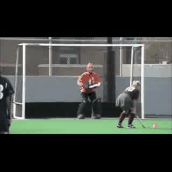

In [17]:
# Create initial states for the stream model
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 172, 172, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in test_ds.take(1):
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    logits, states = model.predict({**states, 'image': clip}, verbose=0)
    all_logits.append(logits)


logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)
# print(all_logits, "logits",logits)
final_probs = probs[-1]
top_k = get_top_k(final_probs)
# print(all_logits)
a = tf.argmax(all_logits[-1][0])
print(a)
print(CLASSES[a])
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

## Export to saved model

In [18]:
saved_model_dir = 'model'
tflite_filename = 'tflite_models/model.int8.fallback.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [6]:
saved_model_dir = 'model'
tflite_filename = 'tflite_models/model.float16.tflite'
input_shape = [1, 1, 172, 172, 3]
# del converter
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

## Convert to TF Lite

In [9]:
def representative_dataset_generator(
    model: tf.keras.Model,
    dataset_iter,
    init_states,
    num_samples_per_video = 3,
    num_calibration_videos = 100
):
  counter = 0
  for i in range(num_calibration_videos):
    example_input, example_label = next(dataset_iter)
    # groundtruth_label_id = tf.argmax(example_label, axis=-1)
    input_states = init_states
    # split video into frames along the temporal dimension.
    frames = example_input
    # frames = tf.split(example_input, example_input.shape[1], axis=1)

    random_indices = np.random.randint(
        low=1, high=len(frames), size=num_samples_per_video)
    # always include the first frame
    random_indices[0] = 0
    random_indices = set(random_indices)
    all_logits = []
    for frame_index, frame in enumerate(frames):
      frame = tf.expand_dims(tf.expand_dims(frame, axis=0), axis=0)
      # print(tf.shape(frame))
      predictions, output_states = model({'image': frame, **input_states})
      # if frame_index in random_indices:
      pred = tf.argmax(predictions[0])
      print("Real: ", CLASSES[example_label], "Pred: ", CLASSES[pred])
      yield {'image': frame, **input_states}
      counter += 1
      # update states for the next inference step
      input_states = output_states
    


init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=input_shape)))

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = functools.partial(representative_dataset_generator, 
#                                                      model=model, dataset_iter=iter(train1_ds.unbatch()), init_states=init_states)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.float32]

# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
print(converter.inference_input_type)
with tf.device('/CPU:0'):
  tflite_model = converter.convert()
tflite_filename = 'tflite_models/model.float32.tflite'
with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)




<dtype: 'float32'>


2023-10-31 21:37:12.443511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-31 21:37:12.443561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-31 21:37:12.443741: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2023-10-31 21:37:12.616206: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-31 21:37:12.616257: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model
2023-10-31 21:37:13.079077: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-31 21:37:14.200290: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: model
2023-10-31 21:37:14.774856: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 2331116 microseconds.
2023-10-31 21:37:1

In [29]:
# Create the interpreter and signature runner
with tf.device('/CPU:0'):
    interpreter = tf.lite.Interpreter(model_path=tflite_filename)

    interpreter.allocate_tensors()
    runner = interpreter.get_signature_runner()
    input_details = runner.get_input_details()
    print(input_details['image'])
    init_states = {
        name: tf.zeros(x['shape'], dtype=x['dtype'])
        for name, x in runner.get_input_details().items()
    }
    del init_states['image']

{'name': 'serving_default_image:0', 'index': 37, 'shape': array([  1,   1, 172, 172,   3], dtype=int32), 'shape_signature': array([  1,   1, 172, 172,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


## Inference using external states on tflite model


FieldHockeyPenalty 0.99999845
ParallelBars 4.552242e-07
CricketBowling 4.197087e-07
SumoWrestling 3.3365572e-07
ShavingBeard 6.468779e-08



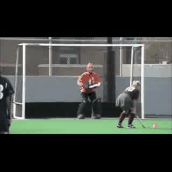

In [33]:
# To run on a video, pass in one frame at a time
states = init_states
for videos, label in test_ds.take(1):
  for frame in videos[0]:
    # Input shape: [1, 1, 172, 172, 3]
    outputs = runner(**states, image=frame)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

In [50]:
cpt = sum([len(files) for r, d, files in os.walk("UCF101_subset/test/")])
print(cpt)

2620


In [40]:
print(type(actual.numpy().tolist()))
print(type([1,2,3]))

<class 'list'>
<class 'list'>


In [51]:
with open('ucf101_label_map.txt', 'w') as file:
    for label in label_names:
        file.write(label+'\n')